<a href="https://colab.research.google.com/github/duke-sunshine/Algorithmic-Trading/blob/main/Sentiment__stock_Jiayi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import Data



1.   Import Tweets from sntwitter API (https://github.com/JustAnotherArchivist/snscrape)

2.   Import daily stock data from Yahoo Finance API (https://pypi.org/project/yfinance/) 

3.   Clean up data - Remove special characters, emojis, memes in each tweets


In [ ]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as mlpt
import csv
!pip install snscrape
!pip install fix_yahoo_finance
!pip install yfinance
import fix_yahoo_finance as yf
import yfinance as yf
import datetime as dt
import snscrape.modules.twitter as sntwitter

In [ ]:
! pip install cryptocmd
! pip install git+git://github.com/guptarohit/cryptoCMD.git

In [ ]:
# TODO: import dependencies
import sys
class DataLoader:
    def __init__(self, stock_id, start, end):
        self.start = start
        self.end = end
        self.stock_id = stock_id
        self.twitter_data = []
        self.stock_price = []
    
    def load_twitter_dataid(self, save = False, savepath = 'Tweets.csv'):
        #Import Tweets from Twitter
        arg1 = '$ %s since:%s until:%s'%(self.stock_id, self.start, self.end)
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(arg1,'corona lang:en').get_items()):
            self.twitter_data.append([tweet.date,  tweet.content]) #tweet.id
        
        self.twitter_data = pd.DataFrame(self.twitter_data, columns=['Date', 'Tweets'])
        data = self.twitter_data
        cdata=pd.DataFrame(columns=['Date','Tweets'])
        index=0
        for index,row in data.iterrows():
            stre=row["Tweets"]
            my_new_string = re.sub('[^ a-zA-Z0-9]', '', stre)
            cdata.sort_index()
            cdata.at[index,'Date']=row["Date"]
            cdata.at[index,'Tweets']=my_new_string
            index=index+1
        self.twitter_data = cdata
        if save:
            self.twitter_data.to_csv(savepath)
        return self.twitter_data

    def load_stock_price(self, save=False, savepath = 'Prices.csv'):
        #Import Stock Market Data from Yahoo! Finance
        data = yf.download(self.stock_id, start=self.start, end=self.end)
        stock_price = pd.DataFrame(data=data)
        stock_price.to_csv(savepath)
        stock_price=pd.read_csv(savepath)
        price=stock_price.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
        price.columns = ["Date",'Prices']   
        self.stock_price = price
        return self.stock_price
        

In [ ]:
#from DataLoader import DataLoader
if __name__ == '__main__':
    dataloader = DataLoader("AAPL","2021-01-01","2021-06-01")

In [ ]:
stock_data=dataloader.load_stock_price(save=True)
tweets_data=dataloader.load_twitter_dataid(save=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_id=dataloader.stock_id

#Sentiment Analysis

Sentiment Analysis is a process of ‘computationally’ evaluating whether a piece of text is positive, negative or neutral. In our case, conducting sentiment analysis on tweets help determine the public's moods towards a stock.
1.   **VADER (Valence Aware Dictionary and Entiment Reasoner)**

```
"VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed
in social media. A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled
according to their semantic orientation aseither positive or negative. VADER not only tells about the Positivity
and Negativity score but also tells us about how positive or negative a sentiment is." (GreeksforGreeks)
```
2.   **Reference**
 
  Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.



In [ ]:
!pip install vaderSentiment
!pip install pyspark
import re
import warnings
import pyspark as spark
import pandas as pd
warnings.filterwarnings('ignore')
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import col,udf,monotonically_increasing_id,unix_timestamp,round,avg
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 125 kB 5.1 MB/s 
     |████████████████████████████████| 212.4 MB 61 kB/s 
     |████████████████████████████████| 198 kB 55.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=7855bb9a3fa73d157e41c26b4af9487bcb751b3073746a518f01d2762d73b96e
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [ ]:
class Sentiment:
  def __init__(self, stock_data, tweets_data):
    self.stock_data = stock_data
    self.tweets_data = tweets_data
    self.tweets_senti=[]
    self.tweets_senti_price=[]
    
  def senti_analysis(self, save = False, savepath = 'Tweets_Senti_Price.csv'):
    tweets=self.tweets_data
    tweets['Date'] = tweets['Date'].astype('datetime64[ns]').dt.date
    sc = spark.SparkContext()
    sql = spark.SQLContext(sc)
    FullDataTw=sql.createDataFrame(tweets).dropna()
    FullDataTw.select(monotonically_increasing_id().alias("rowId"),"*")
    #setting column names of Twitter dataset
    CleanDF = FullDataTw.withColumnRenamed('Tweets', 'Tweet')
    CleanDF = FullDataTw.withColumnRenamed('Date', 'Date_Time')
    analyser = SentimentIntensityAnalyzer()
    def senti_score_udf(sentence):
      snt = analyser.polarity_scores(sentence)
      return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])
    func_udf2 = udf(senti_score_udf, ArrayType(FloatType()))
    CleanDF = CleanDF.withColumn('p_neg', func_udf2(CleanDF['Tweets'])[0])
    CleanDF = CleanDF.withColumn('p_neu', func_udf2(CleanDF['Tweets'])[1])
    CleanDF = CleanDF.withColumn('p_pos', func_udf2(CleanDF['Tweets'])[2])
    CleanDF = CleanDF.withColumn('p_comp', func_udf2(CleanDF['Tweets'])[3])
    FinalTw = CleanDF.drop('Unnamed: 0')
    FinalTw.registerTempTable("temp")
    FinalTw_avg = sql.sql("SELECT Date_Time As DateTime,AVG(p_neg) as P_Neg,AVG(p_neu) as P_Neu,AVG(p_pos) as P_Pos,AVG(p_comp) as P_Comp FROM temp GROUP BY Date_Time")
    tw=FinalTw_avg.toPandas()
    tw.sort_values('DateTime', inplace=True)
    tw=tw.reset_index(drop=True)
    self.tweets_senti = tw
    tw['Prices']=""
    # combine sentiment data and stock price data together in one dataframe
    price=self.stock_data
    for i in range (0,len(tw)):
      for j in range (0,len(price)):
        get_tweet_date=tw["DateTime"].iloc[i]
        get_stock_date=price.Date.iloc[j]
        if(str(get_stock_date)==str(get_tweet_date)):
            tw.at[i,'Prices']=price["Prices"].iloc[j]
            break
    data=tw[tw["Prices"]!=""].reset_index(drop=True)
    self.tweets_senti_price = data
    if save:
      self.tweets_senti_price.to_csv(savepath)
    return self.tweets_senti_price

In [ ]:
sentiment = Sentiment(stock_data,tweets_data)

In [ ]:
sentiment.senti_analysis(save=True)

,DateTime,P_Neg,P_Neu,P_Pos,P_Comp,Prices
0,2021-01-04,0.029083,0.902183,0.068735,0.136296,128.805
1,2021-01-05,0.022272,0.910254,0.067476,0.140894,130.397
2,2021-01-06,0.029555,0.902526,0.067922,0.127885,126.008
3,2021-01-07,0.027377,0.903154,0.069467,0.141057,130.308
4,2021-01-08,0.027229,0.908079,0.064694,0.121686,131.432
...,...,...,...,...,...,...
97,2021-05-24,0.024984,0.909489,0.065523,0.133975,126.91
98,2021-05-25,0.026817,0.911413,0.061766,0.122018,126.71
99,2021-05-26,0.029394,0.910532,0.060071,0.108723,126.66
100,2021-05-27,0.036152,0.902019,0.061819,0.106160,125.093


#3. Statstical Test 

Apply ADF, VAR (with AIC, BIC and FPE), Granger Causality Test to the data.

**Reference**
1. **Augmented Dickey–Fuller test**: Cheung, Y.-W., & Lai, K. S. (1995). Lag order  and critical values of the augmented Dickey–Fuller test. Journal of Business &amp; Economic Statistics, 13(3), 277–280.
2. **Vector Autoregressions**: Stock J, Watson MW. Vector Autoregressions. Journal of Economic Perspectives. 2001;15 (4) :101 – 116. 

    (**Akaike information criterion**): Akaike, H. (1973). Information theory and an extension of the maximum likelihood principle. In B. N. Petrov & B. F. Csaki (Eds.),Second International Symposium on Information Theory, (pp. 267–281). Academiai Kiado: Budapest.
     
    (**Bayesian information criterion**):Schwarz, G. (1978). Estimating the Dimension of a Model. The Annals of Statistics, 6(2), 461–464. https://doi.org/10.1214/aos/1176344136
     
    (**Final Prediction Error (FPE) criterion**):Akaike, H. (1969). Fitting autoregressive models for prediction. Annals of the Institute of Statistical Mathematics, 21(1), 243–247. https://doi.org/10.1007/bf02532251
    
3.  **Granger Causality Test** : Granger, C. W. J. (1969). Investigating Causal Relations by Econometric Models and Cross-Spectral Methods. Econometrica, 37, 424-438
4. **Code** refer to: adfuller (https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), grangercausalitytests (https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html), vector_ar (https://www.statsmodels.org/dev/vector_ar.html), https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2



In [ ]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VARResults

In [ ]:
df_for_causality=pd.read_csv("Tweets_Senti_Price.csv")
df_for_causality['Log_Return'] = np.log(df_for_causality['Prices'])\
- np.log(df_for_causality['Prices'].shift(1))
df_for_causality.fillna(value=0, inplace=True)
df_for_causality=df_for_causality.drop(columns="Unnamed: 0")
df_for_causality.head()

,DateTime,P_Neg,P_Neu,P_Pos,P_Comp,Prices,Log_Return
0,2021-04-01,0.024827,0.907292,0.067874,0.133774,122.607727,0.000000
1,2021-04-05,0.023877,0.907230,0.068897,0.152734,125.498489,0.023304
2,2021-04-06,0.025765,0.911786,0.062438,0.132938,125.807495,0.002459
3,2021-04-07,0.025390,0.910231,0.064383,0.141154,127.492104,0.013302
4,2021-04-08,0.027579,0.908977,0.063449,0.111313,129.944260,0.019051


In [ ]:
class Stats_Test:
  def __init__(self, df_for_causality, variable_y, variable_x):
    self.df_for_causality = df_for_causality
    self.variable_y=variable_y
    self.variable_x=variable_x

  def adf(self):
    arg1 = '%s'%(self.variable_y)
    arg2 = '%s'%(self.variable_x)
    def adf_test(timeseries,arg):
      print("Results of Dickey-Fuller Test for " +arg +":")
      dftest = adfuller(timeseries, autolag='AIC', maxlag=8)
      dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','#Lags Used',
                                             'Number of Observations Used'])
      for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
      print(dfoutput)

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,5))
    ax1.plot(df_for_causality[arg1], label=arg1, color='b')
    ax1.set_title("Visualization of "+ arg1)
    ax1.set_xlabel('Days')
    ax1.legend()

    ax2.plot(df_for_causality[arg2], label=arg2, color='b')
    ax2.set_title("Visualization of "+ arg2)
    ax2.set_xlabel('Days')
    ax2.legend()
    return adf_test(df_for_causality[arg1],arg1), adf_test(df_for_causality[arg2],arg2)

  def VAR_model(self):
    arg1 = '%s'%(self.variable_y)
    arg2 = '%s'%(self.variable_x)
    model = VAR(endog=df_for_causality[[arg1, arg2]])
    results_aic = model.fit(maxlags=7, ic='aic')
    results_bic = model.fit(maxlags=7, ic='bic')
    results_fpe = model.fit(maxlags=7, ic='fpe')
    lag_order_aic = results_aic.k_ar
    lag_order_bic = results_bic.k_ar
    lag_order_fpe = results_fpe.k_ar
    print("The optimal lag deduced by AIC order selection is  "+ str(lag_order_aic))
    print("The optimal lag deduced by BIC order selection is  "+ str(lag_order_bic))
    print("The optimal lag deduced by FPE order selection is  "+ str(lag_order_fpe))

  def granger_causality(self):
    arg1 = '%s'%(self.variable_y)
    arg2 = '%s'%(self.variable_x)
    granger_test_result = grangercausalitytests(df_for_causality[['Prices','P_Comp']].values,maxlag=7)

In [ ]:
stats = Stats_Test(df_for_causality,"Log_Return","P_Comp")

Results of Dickey-Fuller Test for Log_Return:
Test Statistic                -1.046863e+01
p-value                        1.301746e-18
#Lags Used                     0.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64
Results of Dickey-Fuller Test for P_Comp:
Test Statistic                 -3.291901
p-value                         0.015244
#Lags Used                      0.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


(None, None)

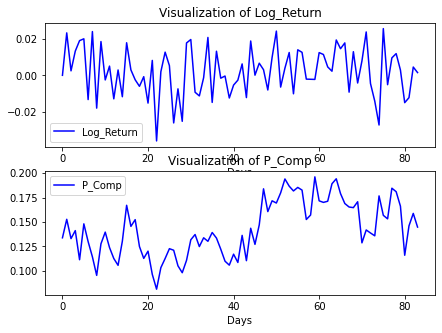

In [ ]:
stats.adf()

In [ ]:
stats.VAR_model()

The optimal lag deduced by AIC order selection is  6
The optimal lag deduced by BIC order selection is  1
The optimal lag deduced by FPE order selection is  6


In [ ]:
stats.granger_causality()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4619  , p=0.0078  , df_denom=80, df_num=1
ssr based chi2 test:   chi2=7.7418  , p=0.0054  , df=1
likelihood ratio test: chi2=7.4017  , p=0.0065  , df=1
parameter F test:         F=7.4619  , p=0.0078  , df_denom=80, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3504  , p=0.0067  , df_denom=77, df_num=2
ssr based chi2 test:   chi2=11.3956 , p=0.0034  , df=2
likelihood ratio test: chi2=10.6703 , p=0.0048  , df=2
parameter F test:         F=5.3504  , p=0.0067  , df_denom=77, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3187  , p=0.0244  , df_denom=74, df_num=3
ssr based chi2 test:   chi2=10.8980 , p=0.0123  , df=3
likelihood ratio test: chi2=10.2246 , p=0.0168  , df=3
parameter F test:         F=3.3187  , p=0.0244  , df_denom=74, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1036  , p=0.0048  , df_d

# 4. Generate buy and sell signals with Visualizations

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')

1.  **Calculate Trading Positions**
 
  https://pandas.pydata.org/docs/reference/api/pandas.Series.ewm.html

  Exponential Moving Average (EMA): Unlike SMA and CMA, exponential moving average is a technical indicator that places a greater weight and significance on the most recent data points  (Investopedia, https://www.investopedia.com/terms/e/ema.asp). 
   $${EMA}_{0} = P_0 $$
   $${EMA}_{t} = (1-\alpha)\ {EMA}_{t-1}+\ \alpha \ P_t $$
   $$\alpha =\frac{2}{s + 1},\text{for span} \ s\geq 1 $$
   
   $s$: decay in terms of span, normally called an "N-day EW moving average".
   
   $EMA_t$: Exponential moving average of day $t$ 

   $P_t$: Closing price of day t
   
   In this case we calculate the difference between Adjusted Closing Price and EMA will give the raw position of the stock. If the difference is positive then we are at a profitable position, so we can consider selling. 

   $\ $
   
2.  **Categorize Sentiments**

  $$\bar{P_{comp}} = \frac{1}{n}\sum_{i=1}^{N}P_{{comp}_i}$$

  $$\sigma_{P_{comp}}=\sqrt{\frac{1}{n}{\sum_{k=1}^n(P_{{comp}_i}-\bar{P_{comp}})^2}}$$

  $$Negative \ Sentiment : P_{comp}<\bar{P_{comp}}-0.2\sigma_{P_{comp}}$$
   
  $$Positive\  Sentiment: P_{comp}>\bar{P_{comp}}+0.2\sigma_{P_{comp}}$$

  $$Neutral \ Sentiment: [\bar{P_{comp}}-0.2\sigma_{P_{comp}} \ ,\bar{P_{comp}}+0.2\sigma_{P_{comp}}\ ]$$

 
3.  **Buy and Sell Signals**

   We calculate the difference between adjusted closing Price and EMA as the raw position of the stock. 
   
  *if raw trading position > 1 and the sentiment is negative, we sell*
   
  *if raw trading position > 1 and the sentiment is positive, we buy*
   
**Reference**

  Part of the code refer to: https://github.com/swapkh91/Algorithmic-Trading

 

In [ ]:
tweets_senti_price=pd.read_csv("Tweets_Senti_Price.csv")

In [ ]:
class Signal:
  def __init__(self,tweets_senti_price, days):
    self.tweets_senti_price = tweets_senti_price
    self.days = days

  def signals(self):
    signal= self.tweets_senti_price
    signal['ema_short'] = signal['Prices'].ewm(span=self.days, adjust=False).mean()
    signal['trading_positions_raw'] = signal['Prices'] - signal.ema_short
    mean_df =signal["P_Comp"].mean()
    std_df =signal["P_Comp"].std()
    left=mean_df-0.2*std_df
    right=mean_df+0.2*std_df
    signal['trading_positions'] = 0
    signal.loc[(signal['trading_positions_raw'] > 1) & (signal["P_Comp"] < left) , 'trading_positions'] = -1
    signal.loc[(signal['trading_positions_raw'] < -1) & (signal["P_Comp"] > right), 'trading_positions'] = 1
    return signal

In [ ]:
signal = Signal(tweets_senti_price, 10)

In [ ]:
signal=signal.signals()
signal

,Unnamed: 0,DateTime,P_Neg,P_Neu,P_Pos,P_Comp,Prices,ema_short,trading_positions_raw,trading_positions
0,0,2021-01-04,0.029083,0.902183,0.068735,0.136296,128.804825,128.804825,0.000000,0
1,1,2021-01-05,0.022272,0.910254,0.067476,0.140894,130.397324,129.094370,1.302954,0
2,2,2021-01-06,0.029555,0.902526,0.067922,0.127885,126.007957,128.533204,-2.525247,1
3,3,2021-01-07,0.027377,0.903154,0.069467,0.141057,130.307755,128.855850,1.451905,0
4,4,2021-01-08,0.027229,0.908079,0.064694,0.121686,131.432465,129.324325,2.108139,0
...,...,...,...,...,...,...,...,...,...,...
97,97,2021-05-24,0.024984,0.909489,0.065523,0.133975,126.909851,126.326324,0.583527,0
98,98,2021-05-25,0.026817,0.911413,0.061766,0.122018,126.710159,126.396112,0.314047,0
99,99,2021-05-26,0.029394,0.910532,0.060071,0.108723,126.660225,126.444132,0.216092,0
100,100,2021-05-27,0.036152,0.902019,0.061819,0.106160,125.092575,126.198395,-1.105820,0


# 4. Generate Return of Investment and Portfolio Flows (cash, holding and total)

1. **Visualize buy and sell signals, closed price and corresponding influential factors including raw trading positions and sentiments**

2. **Generate Return of Investment and portfolio flows**

    ROI= (All the holdings on the last day - Initial capital) / Initial capital
      
3. **Visualize portfolio flows**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

In [ ]:
class Signal_Figure:
  def __init__(self, signal):
    self.signal = signal
   
    
  def signal_figure_raw_trading_positions(self):
    signal=self.signal
    buys = signal[signal['trading_positions'] == 1]
    sells = signal[signal['trading_positions'] == -1]
   
    fig, ax1 = plt.subplots(figsize=(25,10))
    ax1.plot(signal['Prices'], label='Adj Close', color='b')
    ax2 = ax1.twinx()
    ax2.plot(signal["trading_positions_raw"],label="raw trading positions",color="g")
    ax1.plot(signal.iloc[sells.index]['Prices'], 'v', markersize=15, color='b',label = 'selling signal')
    ax1.plot(signal.iloc[buys.index]['Prices'], '^', markersize=15, color='r',label = 'buying signal')
    ax2.axhline(1,0,150,linestyle = "--",label="upper limit")
    ax2.axhline(-1,0,150,linestyle = "--",label="lower limit")
    ax1.set_ylabel('Price')
    ax1.set_xlabel('Days')
    ax1.legend(loc=2)
    ax2.legend()
    ax1.set_title("Visualization of #"+stock_id+" Closed Price, Raw Trading Positions and Buy & Sell Signals")
    plt.show()

  def signal_figure_sentiment_score(self):
    signal=self.signal
    buys = signal[signal['trading_positions'] == 1]
    sells = signal[signal['trading_positions'] == -1]
    fig, ax1 = plt.subplots(figsize=(25,10))
    ax1.plot(signal['Prices'], label='Adj Close', color='b')
    ax2 = ax1.twinx()
    ax2.plot(signal["P_Comp"],label="Sentiment score",color="g")
    ax1.plot(signal.iloc[sells.index]['Prices'], 'v', markersize=15, color='b',label = 'selling signal')
    ax1.plot(signal.iloc[buys.index]['Prices'], '^', markersize=15, color='r',label = 'buying signal')
    ax2.axhline(signal["P_Comp"].mean()-0.2*signal["P_Comp"].std(),0,150,linestyle = "--",label="mean-0.2STD")
    ax2.axhline(signal["P_Comp"].mean()+0.2*signal["P_Comp"].std(),0,150,linestyle = "--",label="mean+0.2STD")
    ax1.set_ylabel('Price')
    ax1.set_xlabel('Days')
    ax1.legend(loc=4)
    ax1.set_title("Visualization of #"+stock_id+" Closed Price, Sentiment and Buy & Sell Signals")
    ax2.legend()
    plt.show()

In [ ]:
signal_figure = Signal_Figure(signal)

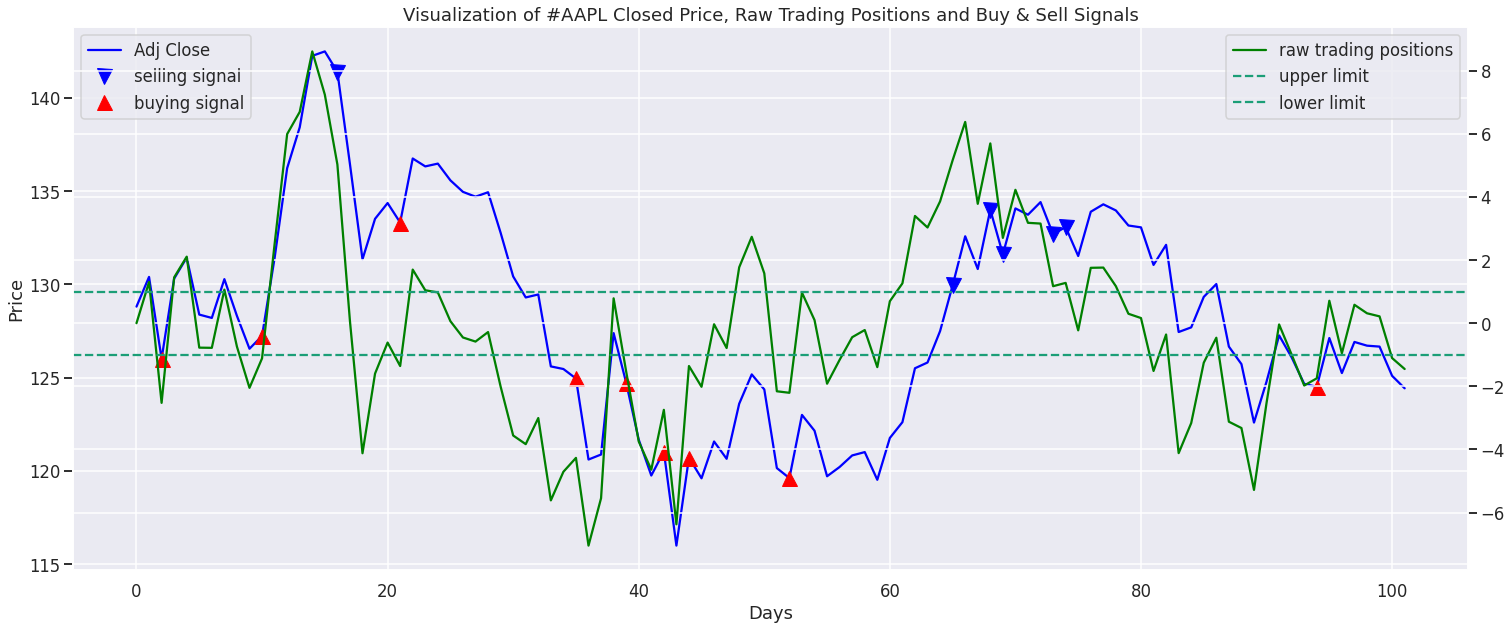

In [ ]:
signal_figure.signal_figure_raw_trading_positions()

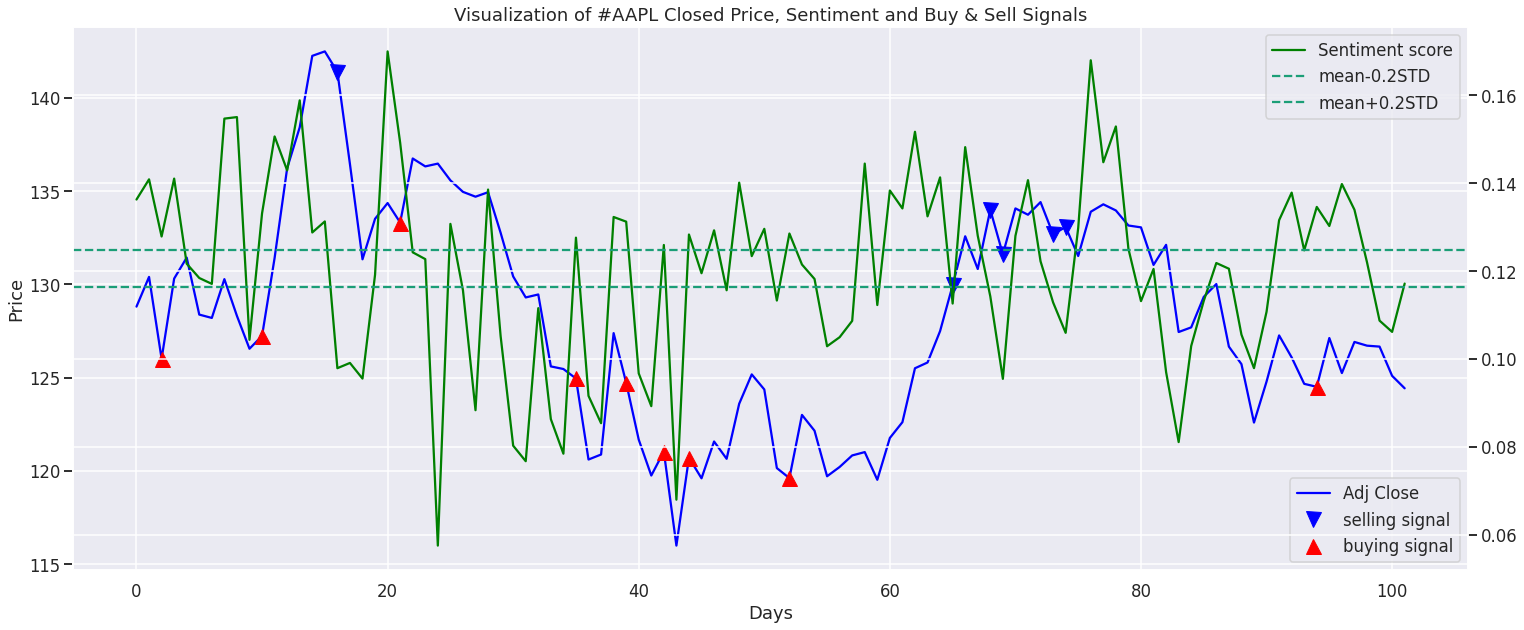

In [ ]:
signal_figure.signal_figure_sentiment_score()

In [ ]:
sclass Portfolio:
  def __init__(self,data,initial_capital=100000,max_buy=10000000,max_sell=10000000):
    self.data = data
    self.initial_capital = initial_capital
    self.max_buy = max_buy
    self.max_sell = max_sell
  def portfolios(self):
    management = self.data
    prices = self.data['Prices']
    states = self.data['trading_positions']
    states_buy = []
    states_sell = []
    cashes = []
    stocks = []
    holdings = []
    cash = self.initial_capital
    stock = 0
    holding = 0
    state = 0
    def buy(i,cash,stock,price):
      shares = cash // price #shares to buy in integer
      if shares<1:
        cash=cash
        stock=stock
        price=price
        holding=stock*price
        print('order %d: total cash %f, not enough to buy 1 share at price %f' % (i, cash, price))
      else:
        if shares>max_buy:
            buy_units = max_buy
        else:
            buy_units = shares
            cost = buy_units*price
        cash -= cost
        stock += buy_units
        holding = stock*price
        print('index %d: buy %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, buy_units, price, cash, stock, holding))
      return cash, stock, holding   

    def sell(i,cash, stock,price):
      if stock == 0:
         print('index %d: cannot sell anything, currentstock 0' % (i))
         cash=cash
         stock=stock
         price=price
         holding=stock*price
      else:
        if stock > self.max_sell:
            sell_units = self.max_sell
        else: 
            sell_units = stock
        stock -=sell_units
        revenue = sell_units*price
        cash += revenue
        price=price
        holding = stock*price
        print('index %d: sell %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, sell_units, price, cash, stock, holding))
      return cash, stock, holding

    for i in range(0, management.shape[0]):
      state = states[i]
      price = prices[i]
      if state == 1:
        cash, stock, holding = buy(i, cash, stock, price)
        states_buy.append(i)
        print(states_buy)
      elif state == -1:
        cash, stock, holding = sell(i,cash, stock, price)
      states_sell.append(i)
      cashes.append(cash)
      stocks.append(stock)
      holdings.append(holding)
    
    management['cash']=cashes
    management['stock']=stocks
    management['holding']=holdings
    management['total']=management['cash']+management['holding']
    management['roi']=(management['total']-self.initial_capital)/self.initial_capital
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(25,30))
    
    ax1.plot(management['holding'], label='Holdings', color='r')
    ax1.plot(management['cash'], label="Cash", color='g')
    ax1.plot(management['total'], label="Total", color='b')
    ax1.set_title("Visualization of #"+ stock_id +" Portfolio Flows")
    ax1.set_xlabel('Days')
    ax1.legend()

    ax2.plot(management["roi"],label="Return on Investment", color="b")
    ax2.set_title("Visualization of #"+ stock_id +" Return on Investment")
    ax2.set_ylabel('ROI')
    ax2.set_xlabel('Days')
   # ax1=management[['holding', 'cash', 'total']].plot(figsize=(14, 10),legend=True)
   # ax2=management[['roi']].plot(figsize=(14, 10),legend=True)
    return management

index 2: buy 793 units at price 126.007957, current cash 75.689735, current stock 793.000000,current holding 99924.310265
[2]
order 10: total cash 75.689735, not enough to buy 1 share at price 127.232201
[2, 10]
index 16: sell 793 units at price 141.395660, current cash 112202.448433, current stock 0.000000,current holding 0.000000
index 21: buy 841 units at price 133.313644, current cash 85.673485, current stock 841.000000,current holding 112116.774948
[2, 10, 21]
order 35: total cash 85.673485, not enough to buy 1 share at price 124.950233
[2, 10, 21, 35]
order 39: total cash 85.673485, not enough to buy 1 share at price 124.720970
[2, 10, 21, 35, 39]
order 42: total cash 85.673485, not enough to buy 1 share at price 121.032768
[2, 10, 21, 35, 39, 42]
order 44: total cash 85.673485, not enough to buy 1 share at price 120.703819
[2, 10, 21, 35, 39, 42, 44]
order 52: total cash 85.673485, not enough to buy 1 share at price 119.607330
[2, 10, 21, 35, 39, 42, 44, 52]
index 65: sell 841 u

,Unnamed: 0,DateTime,P_Neg,P_Neu,P_Pos,P_Comp,Prices,ema_short,trading_positions_raw,trading_positions,cash,stock,holding,total,roi
0,0,2021-01-04,0.029083,0.902183,0.068735,0.136296,128.804825,128.804825,0.000000,0,100000.000000,0.0,0.000000,100000.0,0.0
1,1,2021-01-05,0.022272,0.910254,0.067476,0.140894,130.397324,129.094370,1.302954,0,100000.000000,0.0,0.000000,100000.0,0.0
2,2,2021-01-06,0.029555,0.902526,0.067922,0.127885,126.007957,128.533204,-2.525247,1,75.689735,793.0,99924.310265,100000.0,0.0
3,3,2021-01-07,0.027377,0.903154,0.069467,0.141057,130.307755,128.855850,1.451905,0,75.689735,793.0,99924.310265,100000.0,0.0
4,4,2021-01-08,0.027229,0.908079,0.064694,0.121686,131.432465,129.324325,2.108139,0,75.689735,793.0,99924.310265,100000.0,0.0


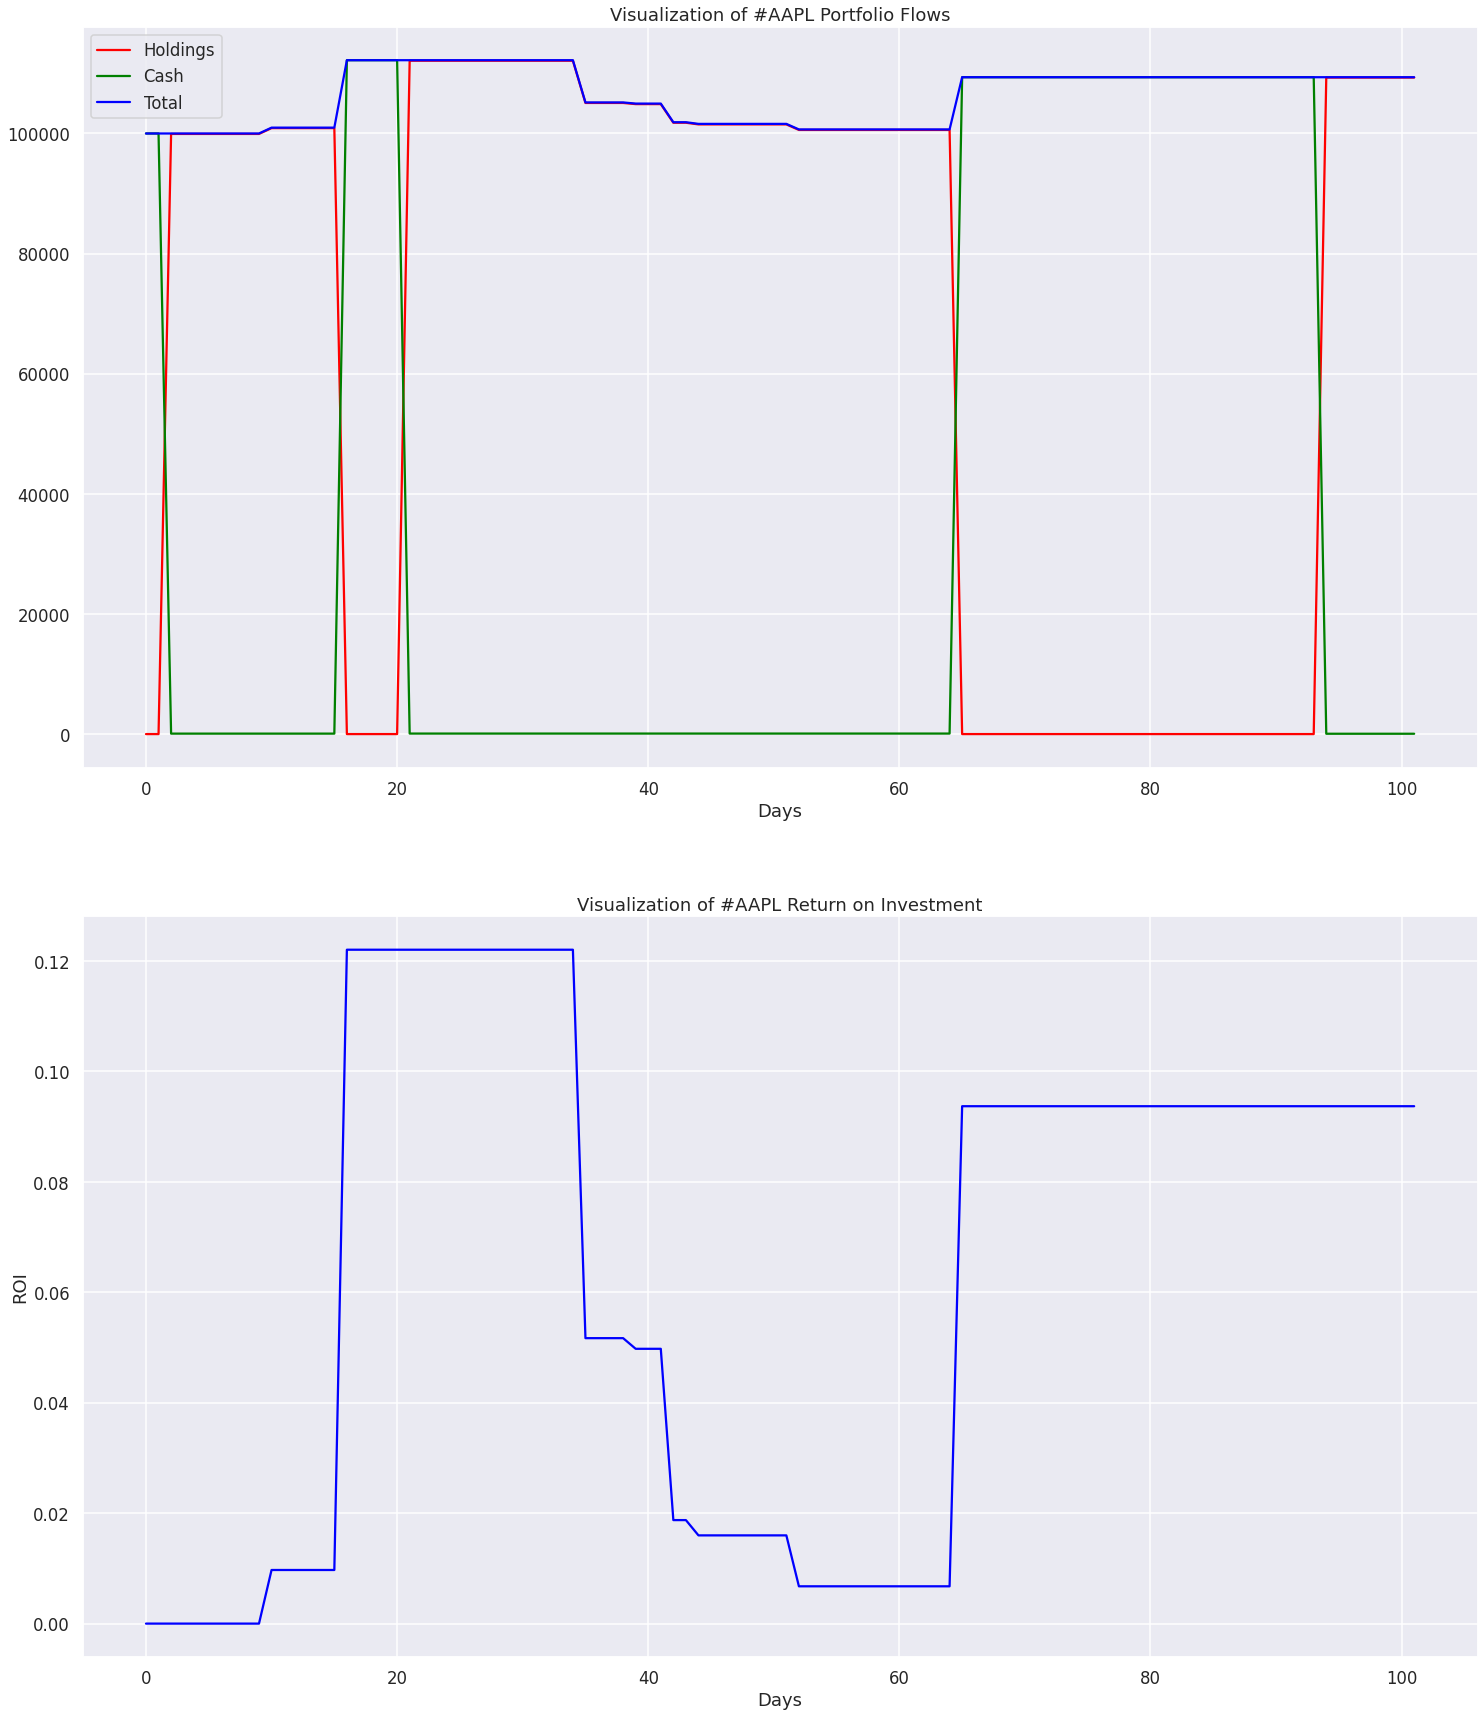

In [ ]:
portfolio = Portfolio(signal)
AAPL_portfolio = portfolio.portfolios()
AAPL_portfolio.head()